# CLASS-HDS Demo

In [1]:
from numbers import Number
import matplotlib.pyplot as plt
import numpy as np
from classy import Class

In [22]:
# Evoke class, set parameters and solve Einstein-Boltzmann
h = 0.6756
def get_model(case):
    c = Class()
    if isinstance(case, Number):
        phi_i = case/np.sqrt(3)
        pars = {
            # Cosmological parameters
            "H0": 100*h,
            "omega_b": 0.022,
            "omega_cdm": 0.12,
            "A_s": 2.215e-9,
            "n_s": 0.962,
            "tau_reio": 0.0544,
            "N_ur": 3.044,
            "N_ncdm": 0,
            "Omega_Lambda": 0.0,
            "Omega_fld": 0.0,
            "Omega_scf": -1.0, # NOTE: setting negative values of Omega_scf will trigger the shooting
            "scf_parameters": f"100,{phi_i}", # NOTE: scf_parameters is organized as follows: the first index represents V0 (it shoots so the value does not matter), the second represents the field initial value
            "YHe": 0.24,
            "scf_tuning_index": 0,
            # CLASS settings
            "lensing": "yes",
            "non_linear": "hmcode",
            "output": "mPk,tCl,pCl,lCl",
            "l_max_scalars": 3000,
            "P_k_max_h/Mpc": 10,
        }
    elif case == "LCDM":
        pars = {
            # Cosmological parameters
            "H0": 67.56,
            "omega_b": 0.022,
            "omega_cdm": 0.12,
            "A_s": 2.215e-9,
            "n_s": 0.962,
            "tau_reio": 0.0544,
            "N_ur": 3.044,
            "N_ncdm": 0,
            "YHe": 0.24,
            # CLASS settings
            "lensing": "yes",
            "non_linear": "hmcode",
            "output": "mPk,tCl,pCl,lCl",
            "l_max_scalars": 3000,
            "P_k_max_h/Mpc": 10,
        }
    c.set(pars)
    c.compute()
    return c

def get_densities(c):
    bg = c.get_background()
    z = bg["z"]
    rho_cdm = bg["(.)rho_cdm"]
    rho_b = bg["(.)rho_b"]
    rho_nu_massless = bg["(.)rho_ur"]
    rho_phot = bg["(.)rho_g"]
    if "(.)rho_scf" in bg.keys(): rho_de = bg["(.)rho_scf"]
    else: rho_de = bg["(.)rho_lambda"]
    rho_tot = bg["(.)rho_tot"]
    return z, rho_cdm, rho_b, rho_phot+rho_nu_massless, rho_de, rho_tot

def get_hubble(c):
    bg = c.get_background()
    return bg["H [1/Mpc]"]


def get_fractions(c):
    z, rho_cdm, rho_b, rho_r, rho_de, rho_tot = get_densities(c)
    return z, rho_cdm/rho_tot, rho_b/rho_tot, rho_r/rho_tot, rho_de/rho_tot

def check_omegas(c):
    z, f_cdm, f_b, f_r, f_scf = get_fractions(c)
    omega_m = (0.022 + 0.12)/(0.6756)**2
    omega_scf = 1 - omega_m - f_r[-1]
    actual_omega_m = f_cdm[-1] + f_b[-1]
    actual_omega_scf = f_scf[-1]
    print(f"Omega_m: expected {omega_m}, got {actual_omega_m}, relative error = {(actual_omega_m-omega_m)/omega_m}")
    print(f"Omega_de: expected {omega_scf}, got {actual_omega_scf}, relative error = {(actual_omega_scf-omega_scf)/omega_scf}")

def get_cls_and_pks(c):
    k = np.logspace(-3, -1, 200) # In h/Mpc
    z = np.zeros(1)
    pk = c.get_pk_array(k*h, z, len(k), 1, True) # NOTE: this function assumes k in 1/Mpc
    class_cls = c.lensed_cl()
    ells = class_cls['ell']
    cls = ells*(ells+1)*class_cls['tt']/(2*np.pi)
    return k, pk*h**3, ells, cls

In [3]:
cases = [8, 10, 15, 20, "LCDM"]
models = {}
for case in cases:
    models[case] = get_model(case)

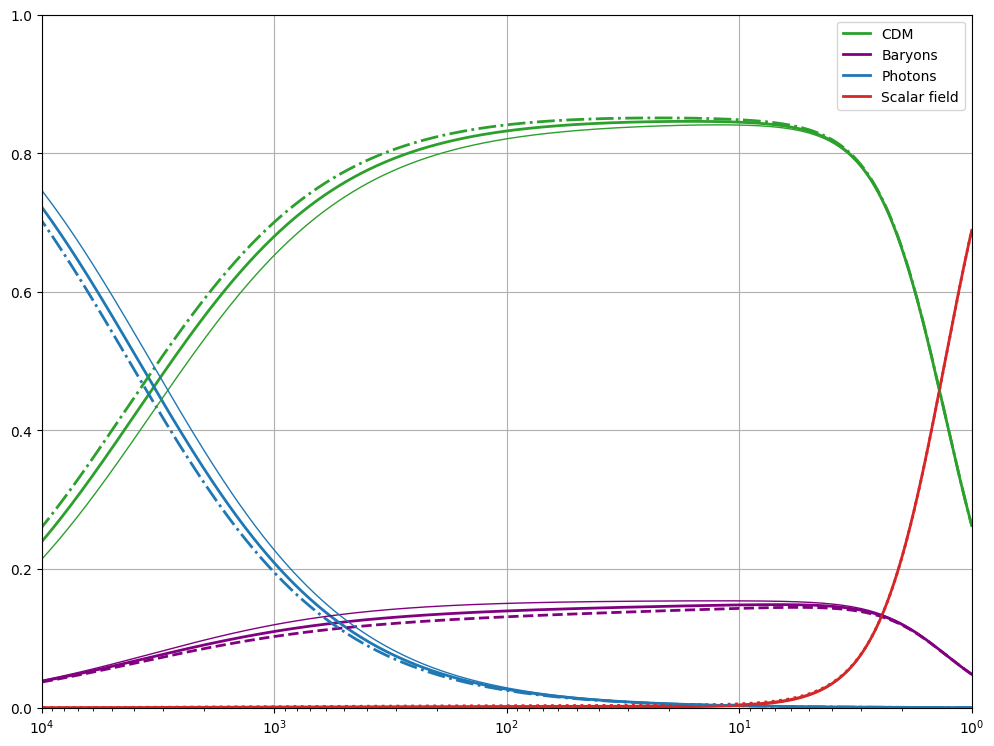

In [4]:
# Figure 1 - left panel
z, f_cdm_8, f_b_8, f_r_8, f_de_8             = get_fractions(models[8])
z, f_cdm_10, f_b_10, f_r_10, f_de_10         = get_fractions(models[10])
z, f_cdm_lcdm, f_b_lcdm, f_r_lcdm, f_de_lcdm = get_fractions(models["LCDM"])

plt.figure(figsize=(12, 9))
lw = 2
plt.semilogx(1+z, f_cdm_10, color="tab:green", label="CDM", lw=lw)
plt.semilogx(1+z, f_b_10, color="purple", label="Baryons", lw=lw)
plt.semilogx(1+z, f_r_10, color="tab:blue", label="Photons", lw=lw)
plt.semilogx(1+z, f_de_10, color="tab:red", label="Scalar field", lw=lw)
plt.semilogx(1+z, f_cdm_8, color="tab:green", ls="-.", lw=lw)
plt.semilogx(1+z, f_b_8, color="purple", ls="--", lw=lw)
plt.semilogx(1+z, f_r_8, color="tab:blue", ls="-.", lw=lw)
plt.semilogx(1+z, f_de_8, color="tab:red", ls=":", lw=lw)
plt.semilogx(1+z, f_cdm_lcdm, color="tab:green", lw=1)
plt.semilogx(1+z, f_b_lcdm, color="purple", lw=1)
plt.semilogx(1+z, f_r_lcdm, color="tab:blue", lw=1)
plt.semilogx(1+z, f_de_lcdm, color="tab:red", lw=1)
plt.xlim([1e4, 1])
plt.ylim([0, 1])
plt.legend()
plt.grid()

Text(0, 0.5, '$\\Delta H/H$ (%)')

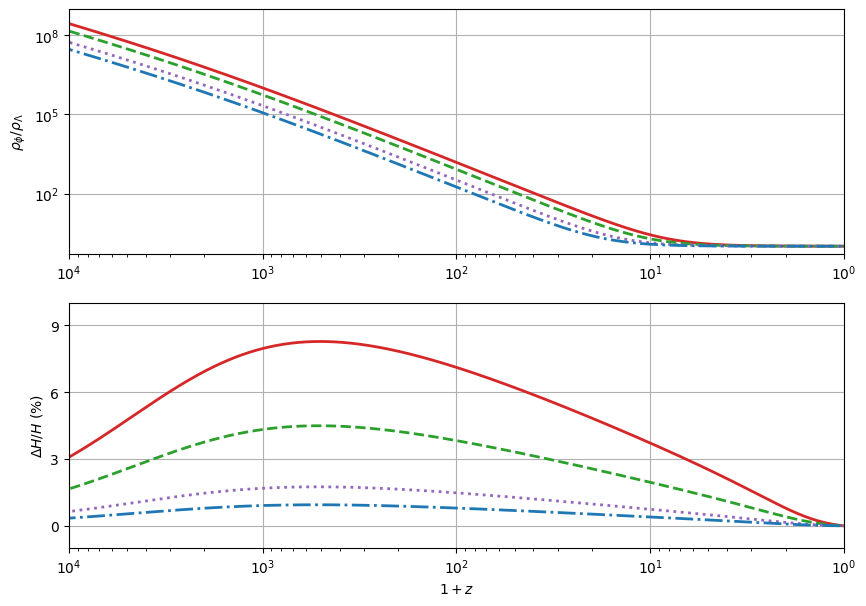

In [7]:
# Figure 1 - right panels
z, rho_cdm_8, rho_b_8, rho_r_8, rho_de_8, rho_tot_8 = get_densities(models[8])
z, rho_cdm_10, rho_b_10, rho_r_10, rho_de_10, rho_tot_10 = get_densities(models[10])
z, rho_cdm_15, rho_b_15, rho_r_15, rho_de_15, rho_tot_15 = get_densities(models[15])
z, rho_cdm_20, rho_b_20, rho_r_20, rho_de_20, rho_tot_20 = get_densities(models[20])
z, rho_cdm_lcdm, rho_b_lcdm, rho_r_lcdm, rho_de_lcdm, rho_tot_lcdm = get_densities(models["LCDM"])

fig, axs = plt.subplots(2, 1, figsize=(10, 7))
axs[0].loglog(1 + z, rho_de_8/rho_de_lcdm, color="tab:red", ls="-", lw=2)
axs[0].loglog(1 + z, rho_de_10/rho_de_lcdm, color="tab:green", ls="--", lw=2)
axs[0].loglog(1 + z, rho_de_15/rho_de_lcdm, color="tab:purple", ls=":", lw=2)
axs[0].loglog(1 + z, rho_de_20/rho_de_lcdm, color="tab:blue", ls="-.", lw=2)

axs[1].semilogx(1 + z, 100*(get_hubble(models[8])/get_hubble(models["LCDM"]) - 1), color="tab:red", ls="-", lw=2)
axs[1].semilogx(1 + z, 100*(get_hubble(models[10])/get_hubble(models["LCDM"]) - 1), color="tab:green", ls="--", lw=2)
axs[1].semilogx(1 + z, 100*(get_hubble(models[15])/get_hubble(models["LCDM"]) - 1), color="tab:purple", ls=":", lw=2)
axs[1].semilogx(1 + z, 100*(get_hubble(models[20])/get_hubble(models["LCDM"]) - 1), color="tab:blue", ls="-.", lw=2)
for ax in axs:
    ax.set_xlim([1e4, 1])
    ax.grid()
axs[0].set_ylim([5e-1, 1e9])
axs[1].set_ylim([-1, 10])
axs[0].set_yticks([1e2, 1e5, 1e8])
axs[1].set_yticks([0, 3, 6, 9])
axs[0].set_ylabel(r"$\rho_\phi/\rho_\Lambda$")
axs[1].set_xlabel(r"$1 + z$")
axs[1].set_ylabel(r"$\Delta H/H$ (%)")

In [8]:
# Checking the omegas
for model in models.values():
    check_omegas(model)

Omega_m: expected 0.31110648394988505, got 0.31110642680142025, relative error = -1.8369422606753423e-07
Omega_de: expected 0.6888018801504285, got 0.6888019372988934, relative error = 8.296792807359396e-08
Omega_m: expected 0.31110648394988505, got 0.3111064833655373, relative error = -1.8782885185997244e-09
Omega_de: expected 0.68880188015775, got 0.6888018807420977, relative error = 8.483537838485857e-10
Omega_m: expected 0.31110648394988505, got 0.311106483952316, relative error = 7.813865863081254e-12
Omega_de: expected 0.6888018801578262, got 0.6888018801553953, relative error = -3.5290747346098995e-12
Omega_m: expected 0.31110648394988505, got 0.31110648395017093, relative error = 9.189214741246908e-13
Omega_de: expected 0.688801880157826, got 0.6888018801575401, relative error = -4.150430436912763e-13
Omega_m: expected 0.31110648394988505, got 0.31110648394988505, relative error = 0.0
Omega_de: expected 0.688801880157826, got 0.688801880157826, relative error = 0.0


/tmp/ipykernel_4620/304640681.py:17: RuntimeWarning: invalid value encountered in divide
  axs[1, 0].semilogx(ell, cl/cl_lcdm, color=color, ls=ls, lw=lw)


Text(0, 0.5, '$\\Delta P(k) / P(k)$')

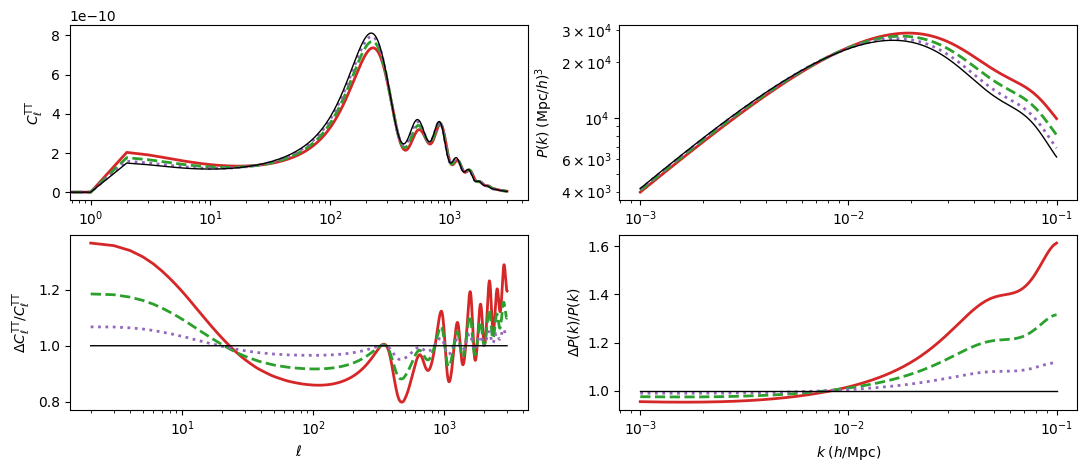

In [28]:
# Extracting P(k) and temperature C_l
fig, axs = plt.subplots(2, 2, figsize=(13, 5))
styles = [
    ["tab:red", "-", 2],
    ["tab:green", "--", 2],
    ["tab:purple", ":", 2],
    [None, None, None],
    ["black", "-", 1],
]
k, pk_lcdm, ell, cl_lcdm = get_cls_and_pks(models["LCDM"])
for (key, model), style in zip(models.items(), styles):
    if key == 20: continue
    color, ls, lw = style
    k, pk, ell, cl = get_cls_and_pks(model)
    axs[0, 0].semilogx(ell, cl, color=color, ls=ls, lw=lw)
    axs[0, 1].loglog(k, pk, color=color, ls=ls, lw=lw)
    axs[1, 0].semilogx(ell, cl/cl_lcdm, color=color, ls=ls, lw=lw)
    axs[1, 1].semilogx(k, pk/pk_lcdm, color=color, ls=ls, lw=lw)

axs[0, 0].set_xlabel(r"$\ell$")
axs[0, 0].set_ylabel(r"$C_\ell^\mathrm{TT}$")
axs[1, 0].set_xlabel(r"$\ell$")
axs[1, 0].set_ylabel(r"$\Delta C_\ell^\mathrm{TT} / C_\ell^\mathrm{TT}$")
axs[0, 1].set_xlabel(r"$k\; (h/\mathrm{Mpc})$")
axs[0, 1].set_ylabel(r"$P(k)\; (\mathrm{Mpc}/h)^3$")
axs[1, 1].set_xlabel(r"$k\; (h/\mathrm{Mpc})$")
axs[1, 1].set_ylabel(r"$\Delta P(k) / P(k)$")